Generating and Testing Phase Screens
============================================

This notebook shows examples of using `aotools` to do the following:
- Create a simple phase screen with atmospheric statistics
- Visualising phase screens
- Checking the statistics of phase screens (Zernike breakdown)
- Infinite phase screens 

In [29]:
import numpy
import matplotlib.pylab as plt
from tqdm import tqdm, trange, tqdm_notebook
from astropy.io import fits
%matplotlib inline

import aotools
from aotools.turbulence import phasescreen, infinitephasescreen
from matplotlib import animation, rc
from IPython.display import HTML

Creating a Phase Screen
-----------------------------

In [12]:
# Set up parameters for creating phase screens

nx_size = 64 # pixels
D = 1. # m 
pxl_scale = D/nx_size # m/pxl
r0 = 0.32 # m 
L0 = 100 # m 
l0 = 1e-3 # m

In [37]:
# Create the phase screen
phase_screen = phasescreen.ft_phase_screen(r0, nx_size, pxl_scale, L0, l0)

Now that we have created a phase screen we can begin to experiment with it.

Seeing the Phase Screen
-----------------------------

The phase screen is a 2D array, with each pixel representing the phase deviation in radians at that point. You can visualise the phase screen using matplotlib:

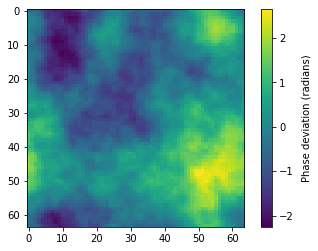

In [53]:
plt.figure()
plt.imshow(phase_screen)
cbar = plt.colorbar()
cbar.set_label('Phase deviation (radians)', labelpad=8)

Zernike Breakdown of Phase Screen
-------------------------------------------

It is useful to check that the screens follow the expected power laws for atmospheric turbulence. To do this we must first calculate the power we expect at each spatial scale and create an array of Zernike modes to compare the phase screen to.

In [54]:
noll = fits.getdata("../noll.fits").diagonal() * (D/r0)**(5./3)
n_zerns = 60
n_scrns = 100
Zs = aotools.zernikeArray(n_zerns, nx_size)

In [55]:
z_coefficients = numpy.zeros((n_scrns, n_zerns))

for n in tqdm(range(n_scrns)):
    phase_screen = phasescreen.ft_phase_screen(r0, nx_size, pxl_scale, L0, l0)
#     phase_screen = phasescreen.ft_sh_phase_screen(r0, nx_size, pxl_scale, L0, l0)
    z_coefficients[n] = (phase_screen * Zs).sum((-1, -2))/(Zs[0].sum())
        
z_variance = z_coefficients.var(0)

100%|██████████| 100/100 [00:00<00:00, 1040.18it/s]


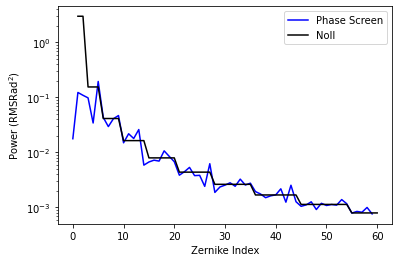

In [56]:
f, a = plt.subplots()
a.plot(z_variance, color="b", label="Phase Screen")
a.plot(range(1, n_zerns+1), noll[:n_zerns] , label="Noll", color="k")
a.set_yscale('log')
a.set_xlabel("Zernike Index")
a.set_ylabel("Power ($\mathrm{RMS Rad}^2$)")
plt.legend()

Note the aliasing effects in some of the Zernike modes and the underestimate of tip/tilt. This illustrates why it is recommended to oversample phase screens compared to pupil size (to mitigate the tip/tilt underestimation), or use techniques such as adding subharmonics to phase screens (try using `phasescreen.ft_sh_phase_screen` in the above example!)

Evolving and Infinite Phase Screens
-----------------------------

Rather than a single square screen, *infinite* phase screens allow extrusion along an axis indefinitely. This can simulate the effect of wind under frozen flow. This is efficient with memory, as the full path of a pupil over a phase screen does not need to be created and stored initially, with new phase being created and old phase lost over timesteps.

First, we need to create an infinite phase screen object

In [57]:
inf_phase_screen = infinitephasescreen.PhaseScreenKolmogorov(nx_size, pxl_scale, r0, L0)

Then, we add a row to the phase screen with the `add_row` function associated with the object 

In [58]:
inf_phase_screen.add_row()

array([[-1.85875932, -1.79385231, -1.67265527, ..., -3.48250628,
        -3.39573104, -3.19550789],
       [-2.1088444 , -1.95032836, -1.73645357, ..., -3.59377794,
        -3.44987802, -3.25155637],
       [-2.35803613, -2.21932749, -1.99520354, ..., -3.54852576,
        -3.42416795, -3.28170514],
       ...,
       [-0.66406624, -0.57864306, -0.54737679, ..., -5.11737625,
        -5.02617745, -5.1025066 ],
       [-0.68607645, -0.56461624, -0.63581019, ..., -5.05098404,
        -5.07980879, -5.14245148],
       [-0.56751482, -0.66659439, -0.83180271, ..., -5.06389013,
        -5.14235602, -5.26267429]])

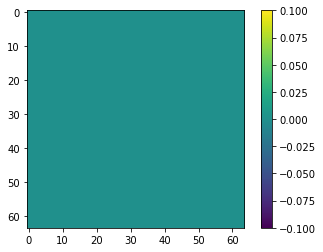

In [59]:
# Video of moving a phase screen
fig, ax = plt.subplots()
image = ax.imshow(numpy.zeros((64, 64)))
fig.colorbar(image)

def init():
    image.set_data(numpy.zeros((64, 64)))
    return (image,)

def animate(i):
    inf_phase_screen.add_row()
    wavefront = inf_phase_screen.scrn
    image.set_data(wavefront)
    image.autoscale()
    return (image,)

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=100, interval=100, 
                               blit=True)

In [60]:
HTML(anim.to_html5_video())